# Тестовое задание на вакансию Product analyst

##### Исполнитель: Сасимович Игорь (e-mail: ihar.sasimovich@gmail.com ; telegram: http://t.me/ihar367)

Условия:

В файле находятся данные за несколько дней по подключениям пользователей к онлайн-документам с целью редактирования в клауде.
Пользователи открывают в клаудные документы, правят их совместно или в одиночку, сохраняют и закрывают их.
Если пользователь не закрывает документ сам, то через полчаса неактивности он автоматически отключается, факт этого также фиксируется в conn_end_time. 
Задача состоит в том, чтобы оценить, сколько в пиковые моменты потребления у нас в эти дни происходило одновременных соединений с документами и визуализировать на подходящей для этого диаграмме.

Для бизнеса данная история важна, так как сервис онлайн документов мы лицензируем у другой компании и платим за него исходя из максимального объема одновременных подключений, который мы выкупили. Сейчас на всех серверах одновременно, исходя из нашего тарифа, мы можем предоставить пользователям не более 3000 одновременных подключений.
В моменты, когда все одновременные подключения превысят эту цифру, новые пользователи при попытке редактировать документ, не смогут это сделать и получат уведомление об ошибке.
Подключением считается каждое пересечение пользователя и документа, т.е. 10 пользователей в одном документе это 10 подключений.

1. В результате анализа нужно увидеть, насколько далеко мы от этих лимитов. 

2. Также найти в данных, что сильнее всего влияет на величину одновременных подключений. Т.е. если бы мы захотели их уменьшить, с какого типа пользователей или порталов нам стоило бы начать.

Задание необходимо выполнить в Jupiter.
При оценке тестового задания важна корректность расчетов, умение делать выводы и формулировать мысли, правильно выбирать тип диаграмм. 

Удачи!

### Приступим к решению.

In [1]:
# Подгружаем библиотеки
import pandas as pd
import numpy as np
import datetime 
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

In [2]:
df = pd.read_excel('task_data.xlsx').sort_values(by='start_edit_time', ascending=True)

df.head()

,server,portal_type,db_name,tariff_id,user,doc_id,start_edit_time,conn_end_time
0,de,box,augcrm.com,box,137augcrm.com,2.152628e+09,2022-12-04 08:07:25,2022-12-05 09:39:44
1,de,box,portal.dalidovitch.com,box,5193portal.dalidovitch.com,3.846962e+09,2022-12-04 15:14:08,2022-12-05 09:11:30
2,ms,cloud,b22452522,ru_pro100,148b22452522,2.382197e+09,2022-12-04 20:14:43,2022-12-05 00:00:26
3,us,cloud,b14804373,la_std,1b14804373,2.372717e+09,2022-12-04 21:08:03,2022-12-05 03:57:19
4,ru,cloud,b12009830,ru_company,250603b12009830,3.757262e+09,2022-12-04 21:42:07,2022-12-05 01:19:32


In [3]:
# Посмотрим на описание df
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 103486 entries, 0 to 103485
Data columns (total 8 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   server           103485 non-null  object        
 1   portal_type      103484 non-null  object        
 2   db_name          103484 non-null  object        
 3   tariff_id        103484 non-null  object        
 4   user             103484 non-null  object        
 5   doc_id           103484 non-null  float64       
 6   start_edit_time  103484 non-null  datetime64[ns]
 7   conn_end_time    103484 non-null  datetime64[ns]
dtypes: datetime64[ns](2), float64(1), object(5)
memory usage: 7.1+ MB


In [4]:
# Посмотрим на дубли
df.duplicated().sum()

0

In [5]:
# Посмотрим на количество пропущенных значений
df.isna().sum()

server             1
portal_type        2
db_name            2
tariff_id          2
user               2
doc_id             2
start_edit_time    2
conn_end_time      2
dtype: int64

In [6]:
x = df.isna().query("doc_id == True").index
df.iloc[x]

,server,portal_type,db_name,tariff_id,user,doc_id,start_edit_time,conn_end_time
103484,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT
103485,Applied filters:\nIncluded (3) 2022 (Year) + Q...,NaN,NaN,NaN,NaN,NaN,NaT,NaT


In [7]:
# Избавимся от пропущенных значений
df = df.dropna()
df.shape

(103484, 8)

In [8]:
print("Количество уникальных значений по колонкам:\n")
print(df[df.columns].nunique())

Количество уникальных значений по колонкам:

server                 4
portal_type            2
db_name             9297
tariff_id            141
user               34653
doc_id             96304
start_edit_time    66728
conn_end_time      64301
dtype: int64


In [9]:
# Посмотрим на временные рамки 
start_min = df.start_edit_time.min()
start_max = df.start_edit_time.max()
end_min = df.conn_end_time.min()
end_max = df.conn_end_time.max()

duration_minutes = round(((end_max - start_min).total_seconds() / 60), 3)
duration_hours = round(duration_minutes / 60, 3)

print(
"Начало пользовательской сессии (start_edit_time) ", '\n',
"* MIN: ", start_min, '\n',
"* MAX: ", start_max, '\n',
"Конец пользовательской сессии (conn_end_time) ", '\n',
"* MIN: ", end_min, '\n',
"* MAX: ", end_max, '\n',
f"Длительность исследуемого периода: {duration_minutes} мин. | {duration_hours} ч.\n",  
sep = '')

Начало пользовательской сессии (start_edit_time) 
* MIN: 2022-12-04 08:07:25
* MAX: 2022-12-06 23:58:00
Конец пользовательской сессии (conn_end_time) 
* MIN: 2022-12-05 00:00:01
* MAX: 2022-12-07 01:30:50
Длительность исследуемого периода: 3923.417 мин. | 65.39 ч.



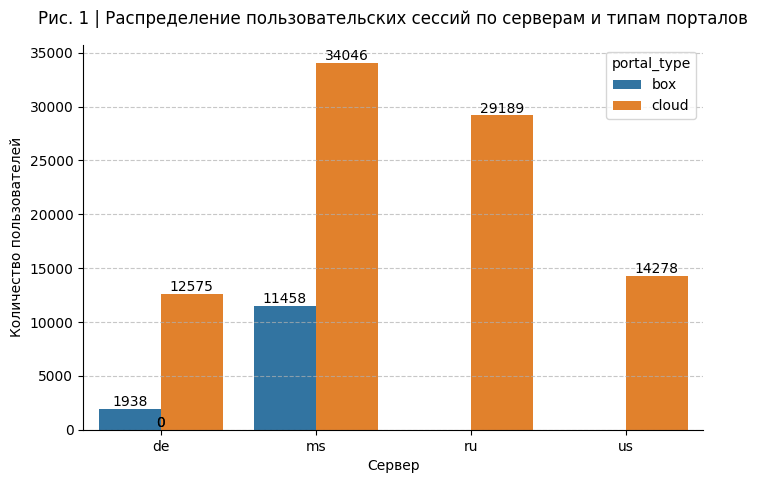

In [10]:
# Посмотрим на распределение данных по серверам и типам порталов

# Подготовка данных
grouped_data = df.groupby(['server', 'portal_type'], as_index=False).agg({'user': 'count'})

# Построение графика
plt.figure(figsize=(8, 5))
ax = sns.barplot(x='server', y='user', hue='portal_type', data=grouped_data)

# Настройка осей и подписей
ax.set(xlabel='Сервер', ylabel='Количество пользователей')
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', 
                xytext=(0, 5), 
                textcoords='offset points')

# Убираем лишние линии и добавляем сетку
sns.despine()
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Устанавливаем заголовок
plt.title('Рис. 1 | Распределение пользовательских сессий по серверам и типам порталов', pad=15)
plt.show()

Видим, что самое большое количество сессий приходится на сервера ms и ru. <br />
Также, мы видим, что тип портала box отсутствует на серверах ru и us. Возможно стоит обратить внимание на это.

In [11]:
# Создадим колонку Длительность сессии (duration). Ед. измерения - минуты.
df['duration'] = ((df['conn_end_time'] - df['start_edit_time']).dt.total_seconds() / 60).round(3)
df.head()

,server,portal_type,db_name,tariff_id,user,doc_id,start_edit_time,conn_end_time,duration
0,de,box,augcrm.com,box,137augcrm.com,2.152628e+09,2022-12-04 08:07:25,2022-12-05 09:39:44,1532.317
1,de,box,portal.dalidovitch.com,box,5193portal.dalidovitch.com,3.846962e+09,2022-12-04 15:14:08,2022-12-05 09:11:30,1077.367
2,ms,cloud,b22452522,ru_pro100,148b22452522,2.382197e+09,2022-12-04 20:14:43,2022-12-05 00:00:26,225.717
3,us,cloud,b14804373,la_std,1b14804373,2.372717e+09,2022-12-04 21:08:03,2022-12-05 03:57:19,409.267
4,ru,cloud,b12009830,ru_company,250603b12009830,3.757262e+09,2022-12-04 21:42:07,2022-12-05 01:19:32,217.417


In [12]:
# Посмотрим на описательные статистики длительности сессии

# Вывод описательной статистики
print(df.duration.describe().round(3), '\n')

# Процентильные значения
percentiles = {
    "90%": 0.90,
    "95%": 0.95,
    "97.5%": 0.975,
    "99%": 0.99
}

# Вывод процентилей
for label, percentile in percentiles.items():
    print(f"{label}: {df['duration'].quantile(percentile).round(3)}")

count    103484.000
mean         21.169
std          36.172
min           0.000
25%           2.383
50%           7.750
75%          31.017
max        1693.700
Name: duration, dtype: float64 

90%: 53.117
95%: 77.233
97.5%: 107.932
99%: 157.539


##### Из верхней строки, мы видим следующее:
1. Среднее значение равно 21.169 мин.
2. Стандартное отклонение равно 36.172 мин.
3. Минимальное значение равно 0 мин. 
   <br /> Максимальное значение равно 1693.7 мин (или 28,228 ч или 43,169 % от длительности исследуемого периода). 
   <br />Соответственно размах распределения составляет 1693.7 мин.
4. Четверть всех наблюдений имеют значение не более 2.383 мин.
5. Половина всех наблюдений имеют значение не более 7.75 мин.
6. 75% всех наблюдений имеют значение не более 31.017 мин.
7. 95% всех наблюдений имеют значение не более 77.233 мин.
7. 99% всех наблюдений имеют значение не более 157.539 мин.

##### Умозаключения:
1. Большое стандартное отклонение говорит о том, что распределение имеющихся данных имеет существенный разброс значений.
2. Размах распределения показывает широкий разброс данных.
3. Исходя из  значений среднего и медианы, можно сделать вывод о том, что распределение данных не является симметричным или нормальным. <b>Медиана значительно меньше среднего значения, что указывает на наличие выбросов в данных, которые существенно влияют на среднее значение. <br />

Визуализируем распределение значений длительности сессий, чтобы убедиться в вышесказанном.

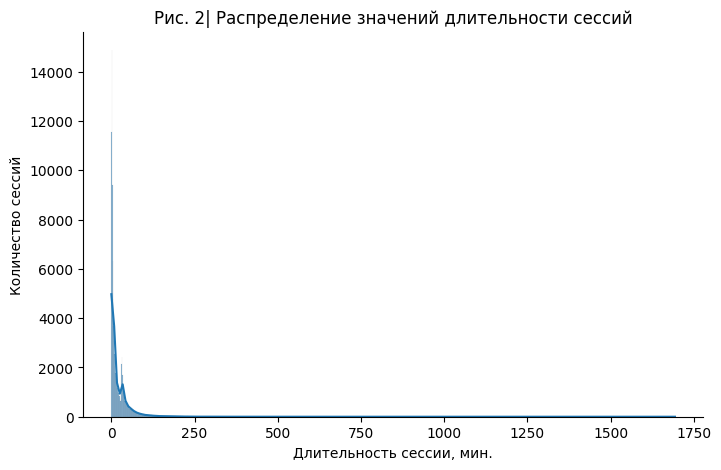

In [13]:
plt.figure(figsize=(8, 5))
sns.histplot(df.duration, kde=True)
plt.xlabel('Длительность сессии, мин.');
plt.ylabel('Количество сессий');
plt.title('Рис. 2| Распределение значений длительности сессий');
sns.despine()

Как мы видим, распределение правосторонне скошенное. <br />
Все значения данного распределения >= 0. <br />
Исходя из предоставленных описательных статистик и гистограммы, мы видим, что данные имеют скошенное распределение с длинным правым хвостом. Это указывает на то, что большинство сессий имеют небольшую длительность, но есть некоторое количество сессий с очень длительными значениями, что приводит к скошенности данных.

Для того, чтобы рассмотреть получше, избавимся от экстремальных значений.<br />

 Для принятия решений по работе с экстремальными значениями нам не хватает  контекста, понимания бизнес-логики и информации об активности каждого пользователя, т.к. колонки 'start_edit_time' 	и 'conn_end_time'	отражают только начало и конец сессии, и никак не характеризуют активность юзера. 

Поэтому, основываясь лишь на имеющихся данных, для исключения экстремальные значений определим пороговое значение для выбросов. 
В нашем случае, правосторонне скошенного распределения , выбросы находятся в правом хвосте.<br />  Воспользуемся методом межквартильного размаха (IQR).

In [14]:
Q1 = df['duration'].quantile(0.25)
Q3 = df['duration'].quantile(0.75)
IQR = Q3 - Q1
upper_bound = Q3 + 1.5 * IQR
lower_bound = Q1 - 1.5 * IQR  
# Учитывая особенности правостороннего экспоненциального распределения, где все значения положительны, смысла в расчёте нижнего пограничного значения смысла нет.

In [15]:
print(
"* Нижнее пороговое значение: ", lower_bound, '\n',
"* Верхнее пороговое значение: ", upper_bound,
sep = '')

* Нижнее пороговое значение: -40.568
* Верхнее пороговое значение: 73.968


Учитывая особенности правостороннего экспоненциального распределения, где все значения положительны, так как duration (длительность) не может быть < 0, смысла в расчёте нижнего пограничного значения смысла нет. <br>
Но на мой взгляд, необходимо избавиться от слишком маленьких значений. Поэтому я решил также убрать записи с длительностью сессии меньше значения 2.5% перцентиля (~30 сек). Данное значение должно определяться c учётом бизнес-логики и контекста. <br /> По моему мнению, это исключит пользователей, случайно или ошибочно зашедших в режим редактирования документов и в последуещем, избавит нас от лишнего шума в данных.

In [16]:
lower_bound = df['duration'].quantile(0.025)
lower_bound

0.483

И так, я определился с пограничными значениями. <br>
Но перед тем, как избавиться от выбросов, поделим наши данные по значению duration на следующие группы:

* extremely_short_period (от 0 до 0.483 мин)

* short_period (от 0.483 до 2.383 мин)

* normal_period (от 2.383 до 31.017 мин)

* long_period (от 31.017 до 73.968)

* very_long_period (от 73.968 до 240)

* extra_long_period (от 240 до 480)

* mega_extra_long_period (от 480)

А затем посмотрим распределение этих групп по серверам и порталам.

In [17]:
cut_period_labels = ['extremely_short_period (0, 0.483]', 'short_period (0.483, 2.383]', 'normal_period (2.383, 31.017]', 'long_period (31.017, 73.968]', 'very_long_period (73.968, 240]', 'extra_long_period (240, 480]', 'mega_extra_long_period (480, max]']
cut_bins = [0, 0.483, 2.383 , 31.017, 73.968, 240, 480, df.duration.max()]
df['duration_groups'] = pd.cut(df['duration'],
                       bins=cut_bins,
                       labels=cut_period_labels)
df.head()

,server,portal_type,db_name,tariff_id,user,doc_id,start_edit_time,conn_end_time,duration,duration_groups
0,de,box,augcrm.com,box,137augcrm.com,2.152628e+09,2022-12-04 08:07:25,2022-12-05 09:39:44,1532.317,"mega_extra_long_period (480, max]"
1,de,box,portal.dalidovitch.com,box,5193portal.dalidovitch.com,3.846962e+09,2022-12-04 15:14:08,2022-12-05 09:11:30,1077.367,"mega_extra_long_period (480, max]"
2,ms,cloud,b22452522,ru_pro100,148b22452522,2.382197e+09,2022-12-04 20:14:43,2022-12-05 00:00:26,225.717,"very_long_period (73.968, 240]"
3,us,cloud,b14804373,la_std,1b14804373,2.372717e+09,2022-12-04 21:08:03,2022-12-05 03:57:19,409.267,"extra_long_period (240, 480]"
4,ru,cloud,b12009830,ru_company,250603b12009830,3.757262e+09,2022-12-04 21:42:07,2022-12-05 01:19:32,217.417,"very_long_period (73.968, 240]"


Посмотрим на распределение данных групп по серверам и типам порталов.

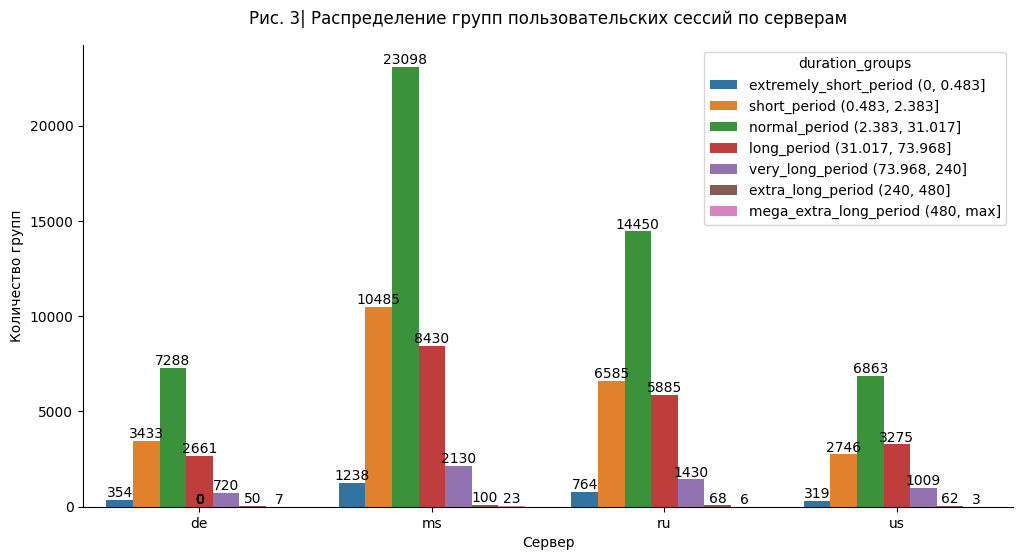

In [18]:
plt.figure(figsize=(12, 6))
zzz = df.groupby(['server', 'duration_groups'], as_index=False, observed=False).agg({'doc_id': 'count'})
ax = sns.barplot(x='server', y='doc_id', hue='duration_groups', data=zzz)

# Настройка осей и заголовка
ax.set(xlabel='Сервер', ylabel='Количество групп')
plt.title('Рис. 3| Распределение групп пользовательских сессий по серверам',  pad=15)
    
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 5), textcoords='offset points')

sns.despine()
plt.show()

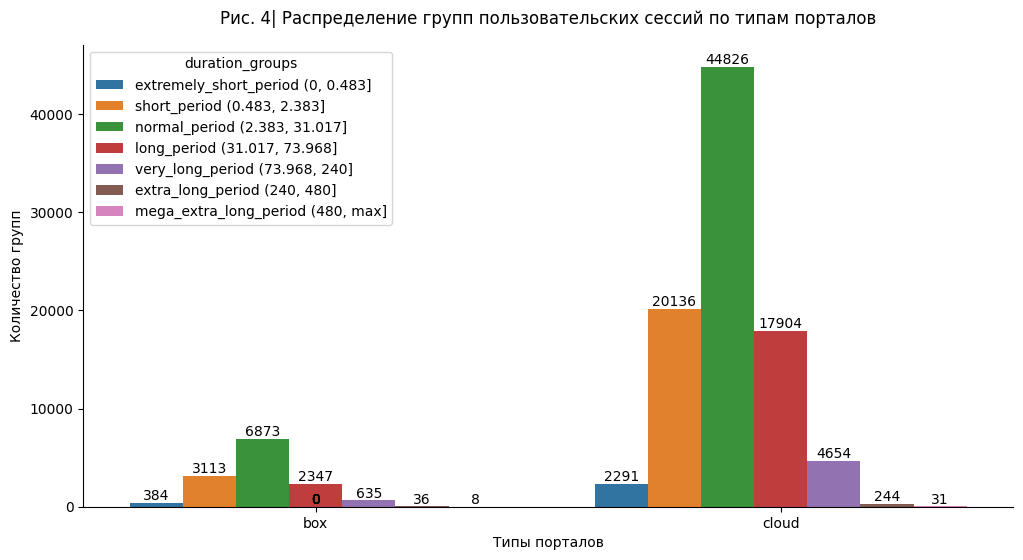

In [19]:
plt.figure(figsize=(12, 6))
zzz = df.groupby(['portal_type', 'duration_groups'], as_index=False, observed=False).agg({'doc_id': 'count'})
ax = sns.barplot(x='portal_type', y='doc_id', hue='duration_groups', data=zzz)
ax.set(xlabel='Типы порталов', ylabel='Количество групп')
plt.title('Рис. 4| Распределение групп пользовательских сессий по типам порталов',  pad=15)
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 5), textcoords='offset points')
sns.despine()
plt.show()

Разумно предположить, что основным фактором, влияющим на количество одновременных сессий, является их длительность, и для у меньшения количества одновременных сессий необходимо её сократить.
Как мы видим, что начать следует с портала "cloud" и серверов "ms" и "ru". т.к. там наибольшее количество чрезвычайно длительных сессий.

Теперь избавимся от выбросов, используя ранее полученные пороговые значения.

In [20]:
df_new = df.sort_values(by='start_edit_time', ascending=True)

In [21]:
df_new = df[(df['duration'] >= lower_bound) & (df['duration'] <= upper_bound)].reset_index(drop=True)
df_new

,server,portal_type,db_name,tariff_id,user,doc_id,start_edit_time,conn_end_time,duration,duration_groups
0,ms,box,crm.rzd-medicine.ru,box,2074crm.rzd-medicine.ru,1.708897e+09,2022-12-04 22:51:35,2022-12-05 00:01:41,70.100,"long_period (31.017, 73.968]"
1,ru,cloud,b9875187,ru_pro,2911b9875187,9.295617e+08,2022-12-04 22:58:22,2022-12-05 00:08:59,70.617,"long_period (31.017, 73.968]"
2,ms,box,b24.astra-best.ru,box,16b24.astra-best.ru,1.810435e+09,2022-12-04 23:10:12,2022-12-05 00:09:55,59.717,"long_period (31.017, 73.968]"
3,ms,cloud,b605443,ru_pro100,14330b605443,2.408088e+09,2022-12-04 23:13:21,2022-12-05 00:07:48,54.450,"long_period (31.017, 73.968]"
4,ru,cloud,b20939060,ru_std,7b20939060,2.233090e+09,2022-12-04 23:25:20,2022-12-05 00:05:13,39.883,"long_period (31.017, 73.968]"
...,...,...,...,...,...,...,...,...,...,...
95378,us,cloud,b18231481,br_pro,6041b18231481,3.032562e+09,2022-12-06 23:55:29,2022-12-06 23:56:20,0.850,"short_period (0.483, 2.383]"
95379,us,cloud,b17426519,br_pro,133b17426519,1.985456e+08,2022-12-06 23:55:35,2022-12-06 23:58:34,2.983,"normal_period (2.383, 31.017]"
95380,de,box,intranet.cardinalscale.com.co,box,3438intranet.cardinalscale.com.co,2.414416e+09,2022-12-06 23:56:58,2022-12-07 00:30:55,33.950,"long_period (31.017, 73.968]"
95381,ms,cloud,b3162457,ru_pro,134078b3162457,4.444441e+06,2022-12-06 23:57:07,2022-12-06 23:59:55,2.800,"normal_period (2.383, 31.017]"


In [22]:
df_new.duration.describe().round(3) 

count    95383.000
mean        15.458
std         17.285
min          0.483
25%          2.433
50%          7.167
75%         25.900
max         73.967
Name: duration, dtype: float64

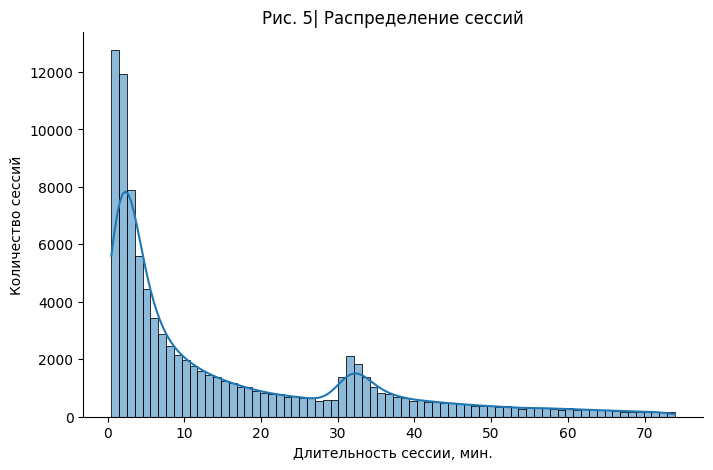

In [23]:
plt.figure(figsize=(8, 5))
sns.histplot(df_new.duration, kde=True)
plt.xlabel('Длительность сессии, мин.');
plt.ylabel('Количество сессий');
plt.title('Рис. 5| Распределение сессий');
sns.despine()

Видим всплеск сессий  длительностью  30 - 35 мин. и нисходящее утолщение хвоста распределения после, что предположительно связано с настройками автоматического отключения (пользователь не закрывает документ сам, через полчаса неактивности он автоматически отключается, что фиксируется в conn_end_time). <br />
Причем, данный всплеск, выпал на значения 30 - 35 мин. не спроста, т.к. если мы вычтем от таких значений 30 мин., то как раз и получим значения из самых частовстречаемых по длительности сессий.

И наконец посчитаем количество одновременных сессий. Под одновременностью будем понимать количество сессий в минуту.

Для этого:

In [24]:
# Построим новый датафрейм с двумя колонками: 'time' c разбивкой исследуемого интервала по минуте 
# и колонкой  simultaneous_sessions, которую для начала заполним нулями.
start_time = start_min
end_time = end_max
time_range = pd.date_range(start=start_time, end=end_time, freq='1min') # Создадим диапазон дат с разбивкой по минуте
df_simultaneous_sessions = pd.DataFrame({'time': time_range, 'simultaneous_sessions': 0})
df_simultaneous_sessions.head()

,time,simultaneous_sessions
0,2022-12-04 08:07:25,0
1,2022-12-04 08:08:25,0
2,2022-12-04 08:09:25,0
3,2022-12-04 08:10:25,0
4,2022-12-04 08:11:25,0


In [25]:
# Создадим цикл, который пройдётся по исходному датафрейму df 
# и в случае попадения значения колонки time (df_simultaneous_sessions) в диапозон между start_edit_time и conn_end_time
# увеличит значение simultaneous_sessions на 1.

# Заполнение колонки simultaneous_sessions значениями из исходного датафрейма df
for index, row in df.iterrows():
    start_time = row['start_edit_time']
    end_time = row['conn_end_time']
    
    # Увеличение значения simultaneous_sessions для каждой минуты в интервале
    mask = (df_simultaneous_sessions['time'] >= start_time) & (df_simultaneous_sessions['time'] <= end_time)
    df_simultaneous_sessions.loc[mask, 'simultaneous_sessions'] += 1

df_simultaneous_sessions.head()

,time,simultaneous_sessions
0,2022-12-04 08:07:25,1
1,2022-12-04 08:08:25,1
2,2022-12-04 08:09:25,1
3,2022-12-04 08:10:25,1
4,2022-12-04 08:11:25,1


Посмотрим на самые большые сессии по дням:

In [26]:
df_simultaneous_sessions['date'] = pd.to_datetime(df_simultaneous_sessions['time']).dt.date

max_sessions_per_day = df_simultaneous_sessions.groupby('date')['simultaneous_sessions'].max().reset_index()

max_sessions_per_day

,date,simultaneous_sessions
0,2022-12-04,79
1,2022-12-05,1828
2,2022-12-06,1593
3,2022-12-07,17


4 декабря 2022 года - воскресенье, возможно, это объясняет небольшое количество одновременных сессий.
Но 7 декабря 2022 года - среда. Нужно разбираться, почему такой маленький онлайн.


In [27]:
plt.figure(figsize=(10, 6))
fig = px.line(df_simultaneous_sessions, x='time', y='simultaneous_sessions')
fig.update_layout(title='Рис. 6 | Изменение количества одновременных сессий во времени ')
fig.add_hline(y=3000, line_dash='dash', line_color='red', annotation_text='Лимит', annotation_position='bottom right')
fig.update_xaxes(title='Время')
fig.update_yaxes(title='Количество одновременных подключений')
fig.show()

# Так как GitHub не поддерживает отображение интерактивных графиков, отобразим его как картинку.

<Figure size 1000x600 with 0 Axes>

Мы получили необходимый график. <br>

![Рис. 6 | Изменение количества одновременных сессий во времени ](https://github.com/i-sasimovich/Test-tasks/blob/main/2023%20Product_analyst_task_cloud_docs_analysis/simultaneous_sessions.png?raw=true)

### Выводы:
1. В пиковые моменты, а именно 05.12.2022 в 11:56:25 и 06.12.2022 в 10:58:25, максимальное значение одновременных подключений не превышало 1828 и 1593 подключения соответственно. На основании имеющихся данных, можем сказать, что по данному тарифу имеется запас, более 1000 подключений. <br>
2. Имеются весьма длительные подключения, которые характеризовать без дополнительной информации по активности юзера и понимания контекста не предоставляется возможным. Могу лишь предположить, что, не срабатывает автоотключение или пользователи используют специальное ПО, вредоносное ПО. <br>    
3. В исследуемый период тарифа хватает, но в случае, если ситуация изменится, возможными методами по уменьшению количества одновременных подключений будут действия направленные на сокращение длительности сессии. Например, сокращение периода автоотключение, установление лимитов на длительность сессии или же уведомление-напоминание об необходимости отдыха/зарядки для глаз и в целом разминки, что вероятно будет полезно для людей ведущих ЗОЖ. <br>
4. 4-ого декабря 2022 - воскресенье. Работать в воскресенье - большой грех. Можно предположить, что наши юзеры весьма набожны 😅. Или же другими словами имеется зависимость от дней недели (будние/выходные), или вообще какой-то сбой. Мало данных. <br>
5. 7-ого декабря 2022 года - среда. Наблюдается минимальная активность. Нужно разбираться, почему такой маленький онлайн.
6. Для более детального анализа не хватает данных, а также понимания контекста. Исследуемый период слишком мал. <br>

##### Спасибо за интересное тестовое! Хорошего дня! 